### Ejercicio en Clase

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## 1. Carga de paquetes

In [59]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import seaborn as sns

## 2. Carga de datos

In [60]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [61]:
data.tail()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575
2019-05-01,11.500000,10813.000,1369.000,6199.000
2019-06-01,10.700000,10848.000,1306.000,6247.000


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2001-01-01 to 2019-06-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TD_13ciudades  222 non-null    float64
 1   Ocupados       222 non-null    float64
 2   Desocupados    222 non-null    float64
 3   Inactivos      222 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB


In [63]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222.000000,222.000000,222.000000,222.000000
mean,12.601883,9160.852009,1290.681131,5500.277973
std,2.808235,1295.492800,181.948810,389.227213
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.396078,7971.103000,1152.874750,5308.814750
50%,11.925036,9139.064500,1270.201000,5533.044500
75%,14.087588,10458.510250,1398.899250,5752.608500
max,20.946380,11037.199000,1834.507000,6395.575000


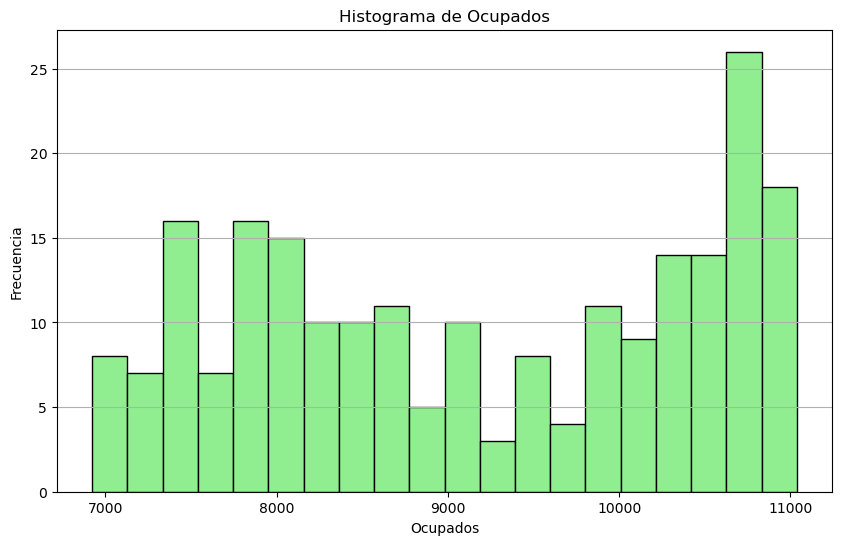

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(data["Ocupados"], bins=20, color='lightgreen', edgecolor='black')
plt.title("Histograma de Ocupados")
plt.xlabel("Ocupados")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

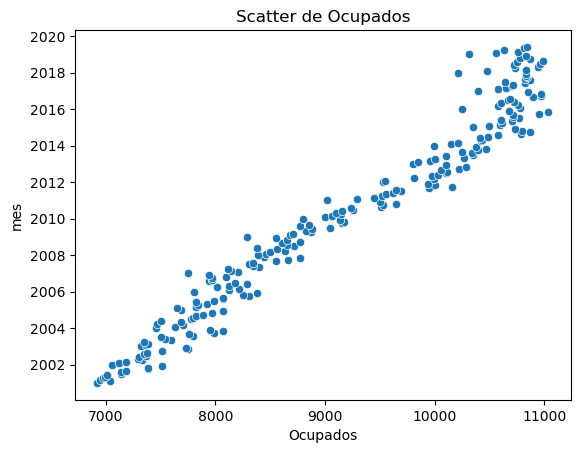

In [103]:
# Scatter plot: mes vs ocupados
sns.scatterplot(x="Ocupados", y="mes", data=data)
plt.title("Scatter de Ocupados")
plt.show()

(222, 4)


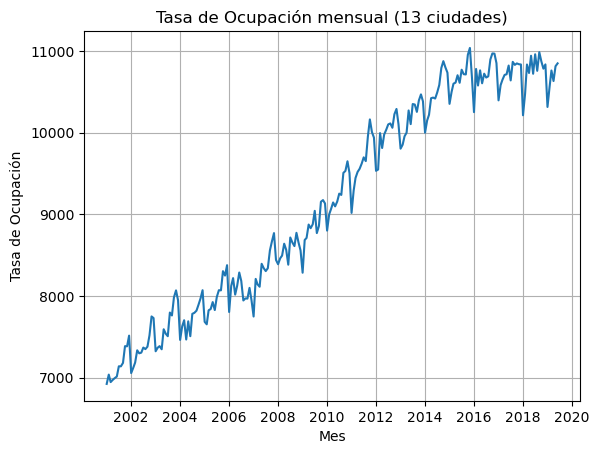

In [66]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de Ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de Ocupación")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## 3. Encontrando los componentes de una serie de tiempo

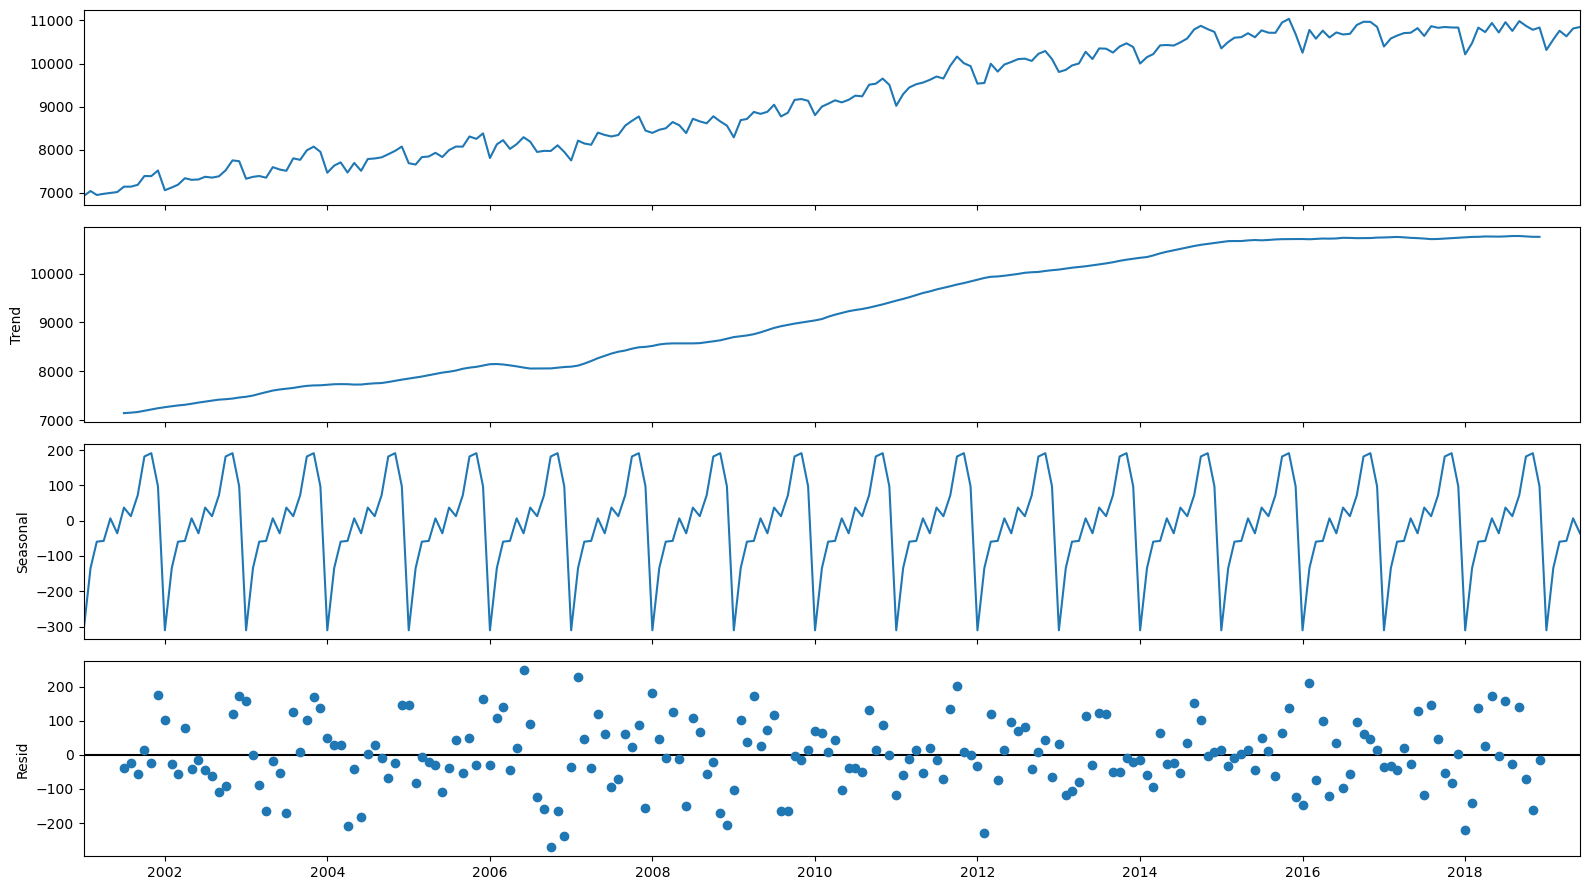

In [67]:
to_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = to_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [68]:
to_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01   -310.570069
2001-02-01   -134.331549
2001-03-01    -59.585841
2001-04-01    -57.385905
2001-05-01      6.435912
                 ...    
2019-02-01   -134.331549
2019-03-01    -59.585841
2019-04-01    -57.385905
2019-05-01      6.435912
2019-06-01    -35.859993
Name: seasonal, Length: 222, dtype: float64

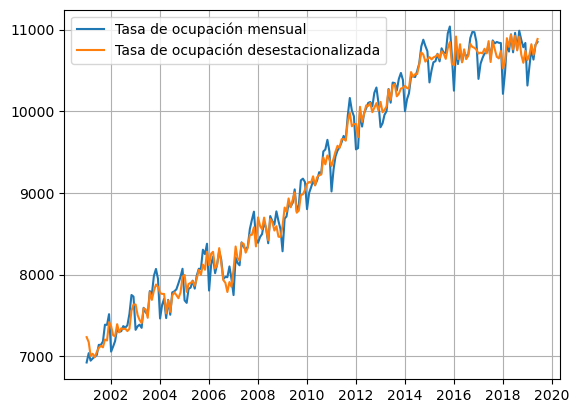

In [69]:
# Desestacionalizar
to_desestacionalizada = data["Ocupados"]-to_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa de ocupación mensual")
plt.plot(to_desestacionalizada,label="Tasa de ocupación desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## 4. Pronosticando metodos de suavización

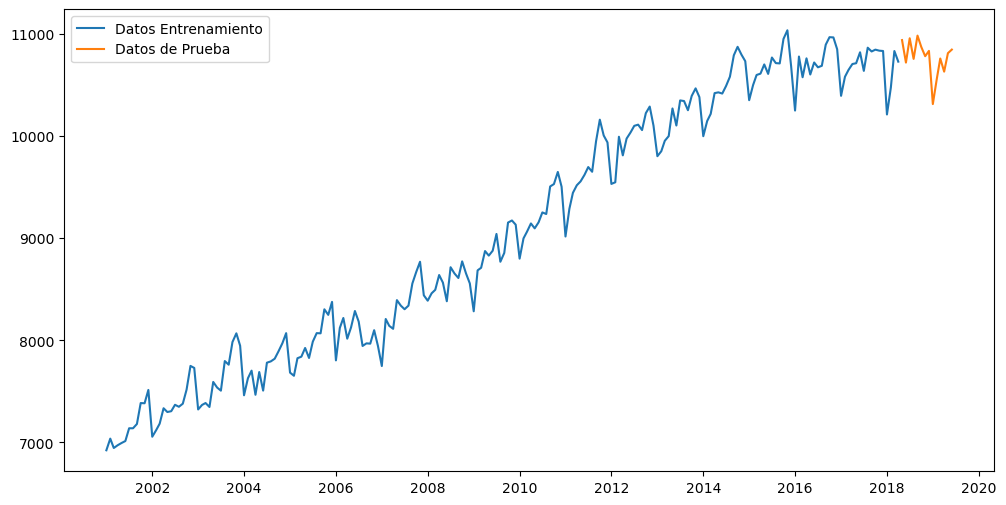

In [70]:
train_len = 208
train_to = data[["Ocupados"]][:train_len]
test_to = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(test_to,label="Datos de Prueba")
plt.legend()
plt.show()

In [71]:
train_to

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [72]:
test_to

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


## 4.1 Promedio movil

In [73]:
## Considerando el dato actual. Números 2,3,4,5 ventanas (datos del más cercano al más lejano para predecir)
ma_2= train_to.rolling(2,min_periods=2).mean()
ma_3= train_to.rolling(3,min_periods=2).mean()
ma_4= train_to.rolling(4,min_periods=2).mean()
ma_5= train_to.rolling(5,min_periods=2).mean()

In [74]:
## Sin considerar el dato actual, por si el periodo no ha finalizado. Preguntar ¿Cuándo debe correr el modelo?
ma_2= train_to.shift().rolling(2,min_periods=2).mean()
ma_3= train_to.shift().rolling(3,min_periods=2).mean()
ma_4= train_to.shift().rolling(4,min_periods=2).mean()
ma_5= train_to.shift().rolling(5,min_periods=2).mean()

In [75]:
#Función para tener en cuenta el nuevo promedio con el anterior para realizar el pronóstico. Considerar el forecast que estoy generando.
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [76]:
# Ventana (2,3,4,5) y cantidad de pronósticos que voy a generar (14).
ma_2_f= fore_ma(train_to,2,14)
ma_3_f= fore_ma(train_to,3,14)
ma_4_f= fore_ma(train_to,4,14)
ma_5_f= fore_ma(train_to,5,14)

In [77]:
test_to

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


In [78]:
ma_2_f

,Ocupados
mes,
2018-05-01,10781.978500
2018-06-01,10755.977750
2018-07-01,10768.978125
2018-08-01,10762.477937
2018-09-01,10765.728031
2018-10-01,10764.102984
2018-11-01,10764.915508
2018-12-01,10764.509246
2019-01-01,10764.712377


In [79]:
# Seleccionar métrica más baja.
rmse_ma_2 = np.sqrt(mean_squared_error(test_to,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_to,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_to,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_to,ma_5_f ))

In [80]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

169.18787998664087 181.43863900870895 212.78442787721826 217.05424156373658


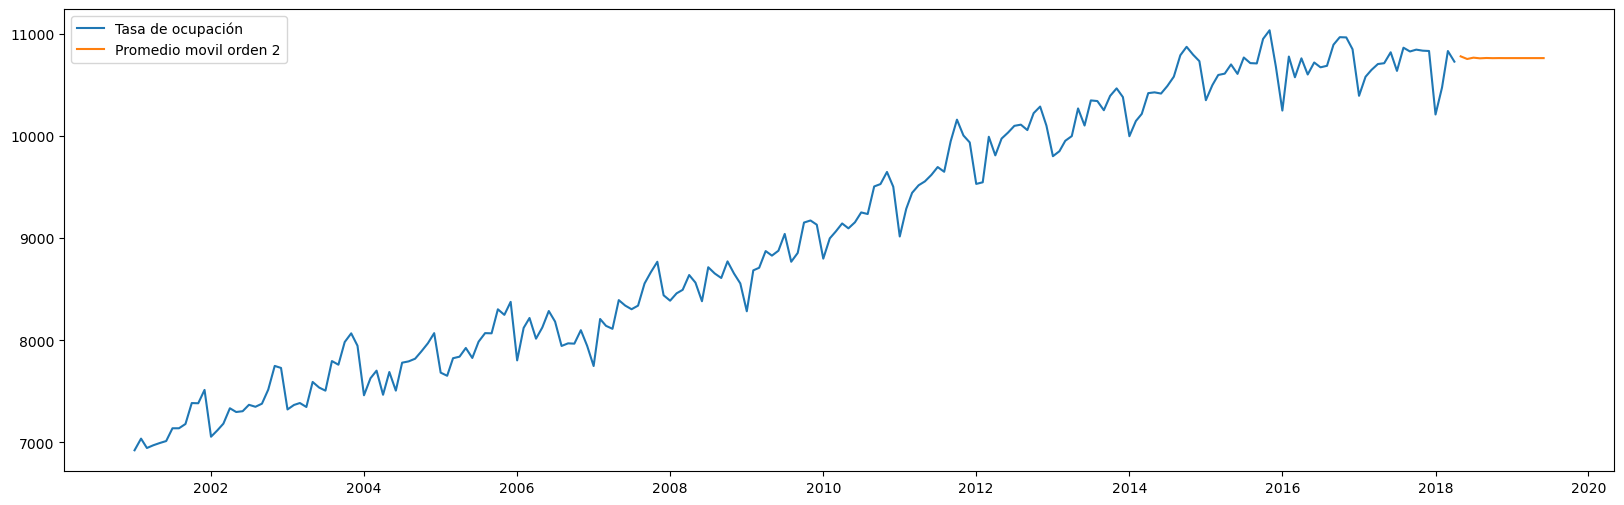

In [81]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_to,label="Tasa de ocupación")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.show()

## 4.2 Suavizacion Exponencial Simple

In [82]:
# Build model.
ets_model = ETSModel(endog=train_to["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10720.369008  10363.683294  11077.054722
2018-06-01    10720.369008  10295.289769  11145.448247
2018-07-01    10720.369008  10236.468170  11204.269846
2018-08-01    10720.369008  10184.059692  11256.678324
2018-09-01    10720.369008  10136.335324  11304.402692
2018-10-01    10720.369008  10092.226504  11348.511512
2018-11-01    10720.369008  10051.018079  11389.719937
2018-12-01    10720.369008  10012.203541  11428.534474
2019-01-01    10720.369008   9975.408613  11465.329402
2019-02-01    10720.369008   9940.347437  11500.390578
2019-03-01    10720.369008   9906.795832  11533.942183
2019-04-01    10720.369008   9874.574131  11566.163884
2019-05-01    10720.369008   9843.535709  11597.202307
2019-06-01    10720.369008   9813.559052  11627.178964


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


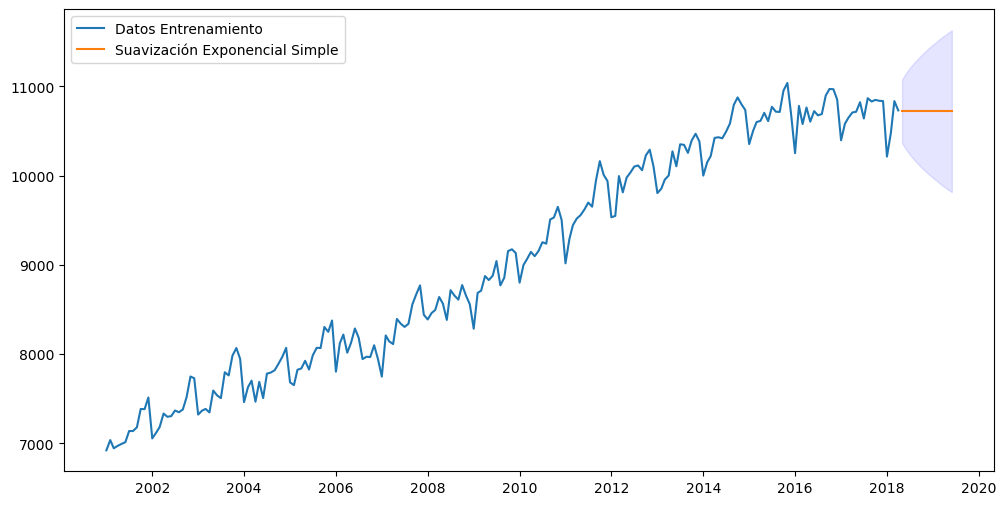

In [83]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [84]:
ets_result.alpha

np.float64(0.6482759040703803)

In [85]:
rmse = np.sqrt(mean_squared_error(test_to,point_forecast ))
print(rmse)

177.99284340591674


## 4.3 Suavizacion Exponencial Lineal (Holt)

In [86]:
# Build model.
ets_model = ETSModel(endog=train_to["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538889  10337.146730  11172.040882
2018-06-01    10773.218986  10332.139460  11255.732051
2018-07-01    10796.951249  10265.185433  11327.283107
2018-08-01    10820.735791  10234.293000  11428.213797
2018-09-01    10844.572728  10249.069906  11508.683280
2018-10-01    10868.462176  10214.240476  11537.673972
2018-11-01    10892.404249  10228.725849  11699.218439
2018-12-01    10916.399064  10159.701069  11726.399109
2019-01-01    10940.446737  10137.393590  11793.122682
2019-02-01    10964.547385  10128.110825  11906.182440
2019-03-01    10988.701124  10097.522804  11895.235120
2019-04-01    11012.908071  10098.780774  11956.129943
2019-05-01    11037.168343  10107.475469  12030.561350
2019-06-01    11061.482058  10114.088493  12045.845228


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


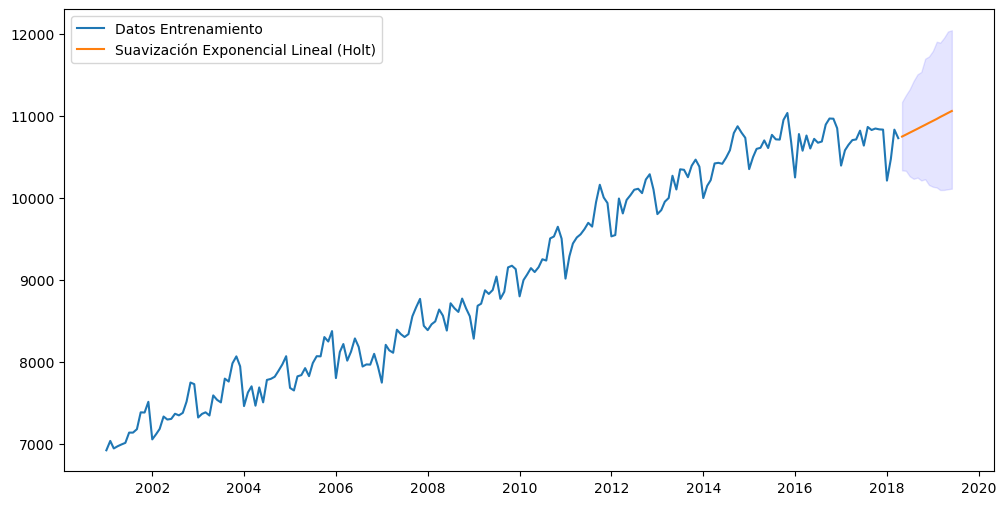

In [87]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [88]:
print(ets_result.alpha,ets_result.beta)

0.561934970994261 5.6193497099426105e-05


In [89]:
rmse_holt = np.sqrt(mean_squared_error(test_to,preds_holt['Point_forecast']))
print(rmse_holt)

261.6153457826458


## 4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)

In [90]:
# Build model
ets_model = ETSModel(endog=train_to["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2018-05-01    10778.689836  10522.784309  11034.595362
2018-06-01    10842.421064  10571.473363  11113.368766
2018-07-01    10833.165419  10547.965033  11118.365806
2018-08-01    10942.075792  10643.299205  11240.852379
2018-09-01    10997.472076  10685.707385  11309.236767
2018-10-01    11095.831213  10771.595832  11420.066593
2018-11-01    11114.775915  10778.529685  11451.022144
2018-12-01    11011.794604  10663.949729  11359.639479
2019-01-01    10524.725150  10165.653885  10883.796415
2019-02-01    10802.735624  10432.776335  11172.694914
2019-03-01    10952.725218  10572.187225  11333.263212
2019-04-01    10962.093054  10571.260559  11352.925549
2019-05-01    10997.212117  10570.372869  11424.051364
2019-06-01    11060.943345  10624.897715  11496.988975


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


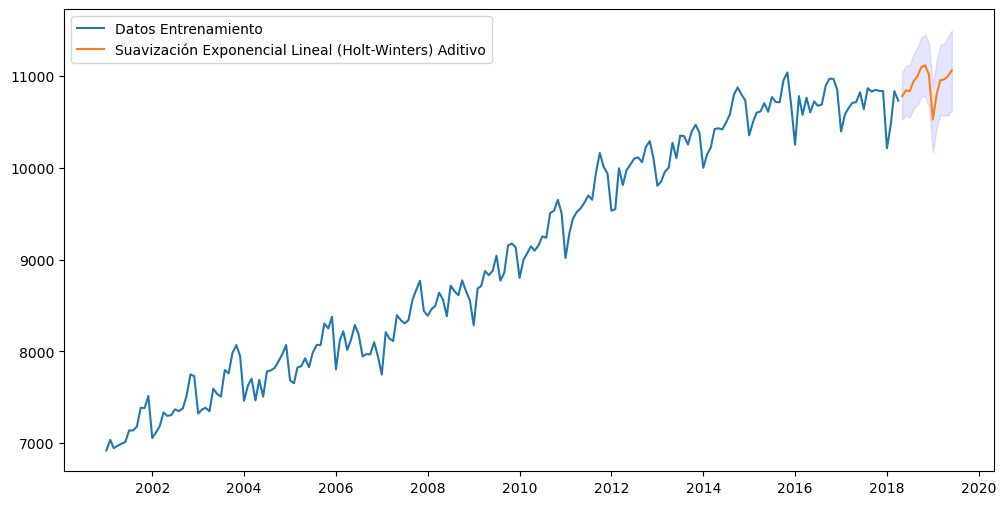

In [91]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [92]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.34783802049331985 3.478380204933199e-05 0.3222492453032009


In [93]:
rmse_hw_add = np.sqrt(mean_squared_error(test_to,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

208.88250573924228


In [94]:
# Build model. Se elimina la tendencia ya que no se encuentra muy marcada y el modelo funciona mejor.
ets_model = ETSModel(endog=train_to["Ocupados"],error="add",trend=None,seasonal="add" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10776.077246  10547.953149  11004.201344
2018-06-01    10745.855187  10479.488797  11012.221577
2018-07-01    10812.863150  10513.094067  11112.632234
2018-08-01    10799.106228  10469.300295  11128.912161
2018-09-01    10849.260063  10491.933318  11206.586809
2018-10-01    10972.295578  10589.421117  11355.170040
2018-11-01    10989.085920  10582.264949  11395.906892
2018-12-01    10888.918650  10459.484426  11318.352874
2019-01-01    10483.652598  10032.737747  10934.567449
2019-02-01    10656.203634  10184.785929  11127.621339
2019-03-01    10721.949644  10230.884371  11213.014917
2019-04-01    10725.740602  10215.784180  11235.697024
2019-05-01    10776.077246  10247.902565  11304.251928
2019-06-01    10745.855187  10200.072315  11291.638060


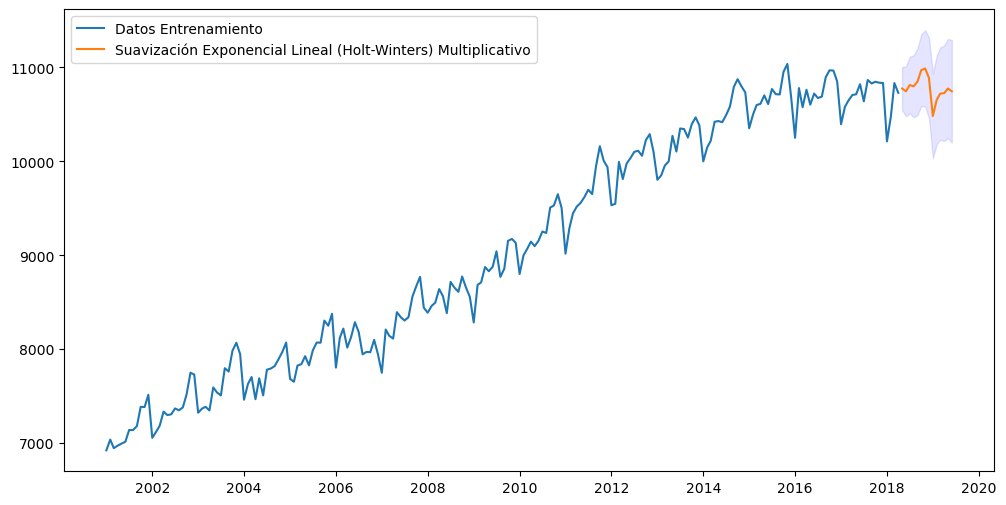

In [95]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [96]:
print(ets_result.alpha,ets_result.gamma)

0.6028090525671199 3.971909474328801e-05


In [97]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_to,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

114.86526408940836


## Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización y se realizan los pronósticos

In [98]:
ets_model = ETSModel(endog=train_to["Ocupados"],error="add",trend=None,seasonal="add" , )
ets_result = ets_model.fit()

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [99]:
## Se obtienen los hiperparametros

print(ets_result.alpha)
#print(ets_result.beta)
print(ets_result.gamma)
print(ets_result.param_names)

0.6028090525671199
3.971909474328801e-05
['smoothing_level', 'smoothing_seasonal', 'initial_level', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [100]:
## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data["Ocupados"],error="add",trend=None,seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.6028090525671199,'smoothing_seasonal': 3.971909474328801e-05})

print(final_model_fit.alpha)
#print(final_model_fit.beta)
print(final_model_fit.gamma)

point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

0.6028090525671199
3.971909474328801e-05
            Point_forecast      lower_95      upper_95
2019-07-01    10879.693431  10650.778123  11108.608739
2019-08-01    10853.702151  10586.411914  11120.992388
2019-09-01    10913.513057  10612.704275  11214.321839
2019-10-01    11023.469843  10692.520034  11354.419652
2019-11-01    11033.196006  10674.629933  11391.762080
2019-12-01    10940.027106  10555.824709  11324.229503


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


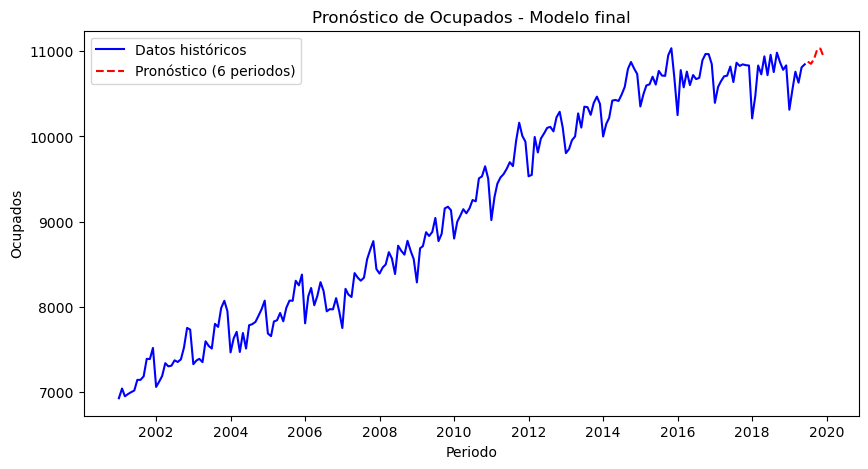

In [104]:
plt.figure(figsize=(10,5))
plt.plot(data["Ocupados"], label="Datos históricos", color="blue")
plt.plot(point_forecast, label="Pronóstico (6 periodos)", color="red", linestyle="--")
plt.title("Pronóstico de Ocupados - Modelo final")
plt.xlabel("Periodo")
plt.ylabel("Ocupados")
plt.legend()
plt.show()